In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sys
import os
if os.path.abspath('../') not in sys.path:
    sys.path.append(os.path.abspath('../'))
if os.path.abspath('../../tt_keras') not in sys.path:
    sys.path.append(os.path.abspath('../../tt_keras'))

if os.path.abspath('../../t3f') not in sys.path:
    sys.path.append(os.path.abspath('../../t3f'))

import automatic_speech_recognition as asr
from automatic_speech_recognition.utils.graph_utils import fixate_rnn_shape
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm
import pickle
import seaborn as sns
sns.set()

os.environ['PATH'] += ':/gpfs/gpfs0/r.schutski/'

# Testing utilities

In [2]:
from glob import glob
import json
from tflite_device_profile import (check_device, run_on_device, parse_profiler_output, batch_profile)
from tflite_device_profile import DEFAULT_PROF_CONFIG as config
from h5_to_tflite import (export_model, batch_export)

In [3]:
os.environ['ANDROID_ADB_SERVER_PORT'] = '5048'  # select which ADB to use. 5037 - local, 5038 - remote

check_device(True, adb_cmd='adb-1.0.39')

# Turn off phone's gpu usage, it can't handle anything
config['use_gpu'] = False
config['num_threads'] = 1
config['enable_op_profiling'] = False
config['num_runs'] = 5000
cpu_affinity = [4]

Found device: AEJ0117C11000167


# Test original deepspeech

In [4]:
!mkdir tflite_models

mkdir: cannot create directory ‘tflite_models’: File exists


In [5]:
deepspeech = asr.model.load_mozilla_deepspeech('./data/myfrozen.pb', verbose=False)
fixate_rnn_shape(deepspeech, 20).save(f'./models/mozilla_deepspeech_tfliteready.h5')
export_model(f'./models/mozilla_deepspeech_tfliteready.h5', f'./tflite_models/mozilla_deepspeech.tflite', run_tests=True)

load graph
Instructions for updating:
Use tf.gfile.GFile.
converting: ./models/mozilla_deepspeech_tfliteready.h5 => ./tflite_models/mozilla_deepspeech.tflite


In [6]:
# profile reference model
ref_res = run_on_device('./tflite_models/mozilla_deepspeech.tflite', 
                        prof_config=config, 
                        cpu_affinity=cpu_affinity)
ref_result = parse_profiler_output(ref_res, is_file=False)
ref_result

ref_time = float(ref_result['main']['avg'])
ref_std = float(ref_result['main']['std'])

print(f"Reference time {ref_time} +- {ref_std}")

Reference time 1473460.0 +- 53162.0


In [7]:
print(ref_res)

STARTING!
Min num runs: [5000]
Min runs duration (seconds): [1]
Max runs duration (seconds): [300]
Inter-run delay (seconds): [-1]
Num threads: [1]
Benchmark name: []
Output prefix: []
Min warmup runs: [30]
Min warmup runs duration (seconds): [0.5]
Graph: [/sdcard/asr_profiling/mozilla_deepspeech.tflite]
Input layers: []
Input shapes: []
Use nnapi : [0]
nnapi execution preference: [sustained_speed]
Use legacy nnapi : [0]
Use gpu : [0]
Allow lower precision in gpu : [0]
Preferred GL object type in gpu : [0]
Allow fp16 : [0]
Require full delegation : [0]
Enable op profiling: [0]
Max profiling buffer entries: [1024]
Loaded model /sdcard/asr_profiling/mozilla_deepspeech.tflite
resolved reporter
`--use_nnapi=true` must be set for the provided NNAPI execution preference (sustained_speed) to be used.
Initialized session in 1.768ms
Running benchmark for at least 30 iterations and at least 0.5 seconds but terminate if exceeding 300 seconds.
count=30 first=1816888 curr=1302607 min=1266999 max=18

# Convert maxvol models to tflite

In [8]:
for filename in os.listdir('./models'):
    if 'tfliteready' not in filename and (filename.startswith('lstm_desnse234') or filename.startswith('special')):
        name = filename[:filename.rindex('.')]
        # skip if already converted
        if os.path.exists(f'./tflite_models/{name}.tflite'):
            continue
        # fixate shape
        print(f"Start fixating {name}")
        fixate_rnn_shape(keras.models.load_model(f'./models/{name}.h5', compile=False), 20).save(f'./models/{name}_tfliteready.h5')
        # export dense model
        export_done = False
        while not export_done:
            try:
                export_model(f'./models/{name}_tfliteready.h5', f'./tflite_models/{name}.tflite', run_tests=False)
                export_done = True
            except AssertionError as e:
                print(f'Failed with {str(e)}')

Start fixating lstm_desnse234_1vol_tol1.1_maxvolled_deepspeech_r1900
converting: ./models/lstm_desnse234_1vol_tol1.1_maxvolled_deepspeech_r1900_tfliteready.h5 => ./tflite_models/lstm_desnse234_1vol_tol1.1_maxvolled_deepspeech_r1900.tflite


Start fixating special_r_1200_1000_1700_1900
converting: ./models/special_r_1200_1000_1700_1900_tfliteready.h5 => ./tflite_models/special_r_1200_1000_1700_1900.tflite


Start fixating special_r_1000_700_1500_0
converting: ./models/special_r_1000_700_1500_0_tfliteready.h5 => ./tflite_models/special_r_1000_700_1500_0.tflite


Start fixating lstm_desnse234_1vol_tol1.05_maxvolled_deepspeech_r1900
converting: ./models/lstm_desnse234_1vol_tol1.05_maxvolled_deepspeech_r1900_tfliteready.h5 => ./tflite_models/lstm_desnse234_1vol_tol1.05_maxvolled_deepspeech_r1900.tflite


Start fixating special_r_500_300_1000_1700
converting: ./models/special_r_500_300_1000_1700_tfliteready.h5 => ./tflite_models/special_r_500_300_1000_1700.tflite


Start fixating lstm_desnse234_2vol_tol1.01_maxvolled_deepspeech_r1900
converting: ./models/lstm_desnse234_2vol_tol1.01_maxvolled_deepspeech_r1900_tfliteready.h5 => ./tflite_models/lstm_desnse234_2vol_tol1.01_maxvolled_deepspeech_r1900.tflite


Start fixating lstm_desnse234_1vol_tol1.01_maxvolled_deepspeech_r1900
converting: ./models/lstm_desnse234_1vol_tol1.01_maxvolled_deepspeech_r1900_tfliteready.h5 => ./tflite_models/lstm_desnse234_1vol_tol1.01_maxvolled_deepspeech_r1900.tflite


Start fixating special_r_1300_1300_1900_0
converting: ./models/special_r_1300_1300_1900_0_tfliteready.h5 => ./tflite_models/special_r_1300_1300_1900_0.tflite


Start fixating lstm_desnse234_2vol_tol1.1_maxvolled_deepspeech_r1900
converting: ./models/lstm_desnse234_2vol_tol1.1_maxvolled_deepspeech_r1900_tfliteready.h5 => ./tflite_models/lstm_desnse234_2vol_tol1.1_maxvolled_deepspeech_r1900.tflite


Start fixating special_r_900_500_1300_1700
converting: ./models/special_r_900_500_1300_1700_tfliteready.h5 => ./tflite_models/special_r_900_500_1300_1700.tflite


Start fixating special_r_1200_1000_1700_0
converting: ./models/special_r_1200_1000_1700_0_tfliteready.h5 => ./tflite_models/special_r_1200_1000_1700_0.tflite


Start fixating special_r_1300_1300_1900_1900
converting: ./models/special_r_1300_1300_1900_1900_tfliteready.h5 => ./tflite_models/special_r_1300_1300_1900_1900.tflite


Start fixating lstm_desnse234_2vol_tol1.05_maxvolled_deepspeech_r1900
converting: ./models/lstm_desnse234_2vol_tol1.05_maxvolled_deepspeech_r1900_tfliteready.h5 => ./tflite_models/lstm_desnse234_2vol_tol1.05_maxvolled_deepspeech_r1900.tflite


Start fixating special_r_1000_700_1500_1900
converting: ./models/special_r_1000_700_1500_1900_tfliteready.h5 => ./tflite_models/special_r_1000_700_1500_1900.tflite


Start fixating special_r_3000_100_300_1200
converting: ./models/special_r_3000_100_300_1200_tfliteready.h5 => ./tflite_models/special_r_3000_100_300_1200.tflite


In [ ]:
test_results = {}
for filename in os.listdir('./tflite_models'):
    if 'maxvolled' in filename and filename.startswith('lstm_desnse234'):
        name = filename[:filename.rindex('.')]
        print(f"Profiling {name}")
        # profile model
        res = run_on_device(f'./tflite_models/{filename}', 
                                prof_config=config, 
                                cpu_affinity=cpu_affinity)
        result = parse_profiler_output(res, is_file=False)
        time = float(result['main']['avg'])
        std = float(result['main']['std'])

        print(f"Time for {name} is {time} +- {std}")
        test_results[name] = (time, std)
with open('./maxvol_stats/speeduptest_with_tol_.pickle', 'wb+') as f:
    pickle.dump(test_results, f)

Profiling lstm_desnse234_2vol_tol1.05_maxvolled_deepspeech_r1700
Time for lstm_desnse234_2vol_tol1.05_maxvolled_deepspeech_r1700 is 1248530.0 +- 4984.0
Profiling lstm_desnse234_1vol_tol1.05_maxvolled_deepspeech_r700


In [9]:
special_test_results = {}
for filename in os.listdir('./tflite_models'):
    if filename.startswith('special_'):
        name = filename[:filename.rindex('.')]
        print(f"Profiling {name}")
        # profile model
        res = run_on_device(f'./tflite_models/{filename}', 
                                prof_config=config, 
                                cpu_affinity=cpu_affinity)
        result = parse_profiler_output(res, is_file=False)
        time = float(result['main']['avg'])
        std = float(result['main']['std'])

        print(f"Time for {name} is {time} +- {std}")
        special_test_results[name] = (time, std)
with open('./maxvol_stats/speeduptest_with_tol_special_.pickle', 'wb+') as f:
    pickle.dump(special_test_results, f)

Profiling special_r_900_500_1300_1700
Time for special_r_900_500_1300_1700 is 863616.0 +- 31451.0
Profiling special_r_1000_700_1500_1900
Time for special_r_1000_700_1500_1900 is 1024260.0 +- 67122.0
Profiling special_r_1000_700_1500_0
Time for special_r_1000_700_1500_0 is 1219090.0 +- 77559.0
Profiling special_r_1300_1300_1900_1900
Time for special_r_1300_1300_1900_1900 is 1361420.0 +- 29718.0
Profiling special_r_1300_1300_1900_0
Time for special_r_1300_1300_1900_0 is 1487320.0 +- 9002.0
Profiling special_r_1200_1000_1700_1900
Time for special_r_1200_1000_1700_1900 is 1284400.0 +- 3693.0
Profiling special_r_3000_100_300_1200
Time for special_r_3000_100_300_1200 is 599998.0 +- 3671.0
Profiling special_r_500_300_1000_1700
Time for special_r_500_300_1000_1700 is 922995.0 +- 5206.0
Profiling special_r_1200_1000_1700_0
Time for special_r_1200_1000_1700_0 is 1364340.0 +- 6616.0


In [8]:
with open('./maxvol_stats/speeduptest_with_tol_.pickle', 'rb') as f:
    test_results = pickle.load(f)
with open('./maxvol_stats/speeduptest_with_tol_special_.pickle', 'rb') as f:
    special_test_results = pickle.load(f)

In [9]:
special_test_results_test_results

{'special_r_900_500_1300_1700': (868547.0, 18039.0),
 'special_r_1000_700_1500_1900': (1064570.0, 79913.0),
 'special_r_1000_700_1500_0': (1250320.0, 50192.0),
 'special_r_1300_1300_1900_0': (1485280.0, 26029.0),
 'special_r_1200_1000_1700_1900': (1365680.0, 3887.0),
 'special_r_1200_1000_1700_0': (1367830.0, 8485.0)}

In [10]:
def get_run_rank(name):
    return int(name[name.index('_r') + 2:])

def get_run_name(name):
    return name[:name.index('_2vol_tol')]

def get_run_tol(name):
    tol_start = name.index('_tol') + 4
    tol_end = name.index('_', tol_start)
    return float(name[tol_start:tol_end])

def get_run_maxvol_type(name):
    if '2vol' in name:
        return '2vol'
    elif '1vol' in name:
        return '1vol'
    else:
        raise ValueError(f"Name {name} is incorrect")

def is_full_change(name):
    return name.startswith('lstm_desnse234_')

In [11]:
full_change_ranks = []
full_change_tol = []
full_change_avg = []
full_change_std = []
full_change_maxvol_type = []
for result_name, result_data in test_results.items():
    if is_full_change(result_name):
        full_change_ranks.append(get_run_rank(result_name))
        full_change_tol.append(get_run_tol(result_name))
        full_change_avg.append(result_data[0])
        full_change_std.append(result_data[1])
        full_change_maxvol_type.append(get_run_maxvol_type(result_name))
speed_results = pd.DataFrame.from_dict({
    'avg': full_change_avg,
    'std': full_change_std,
    'rank': full_change_ranks,
    'maxvol_type': full_change_maxvol_type,
    'tol': full_change_tol
})
speed_results.sort_values('rank', inplace=True)
speed_results

,avg,std,rank,maxvol_type,tol
53,23691.0,1098.0,100,1vol,1.10
39,23752.7,1154.0,100,1vol,1.01
31,34758.7,1287.0,100,2vol,1.10
28,23830.3,1202.0,100,1vol,1.05
43,40905.8,1829.0,100,2vol,1.01
7,37261.2,1508.0,100,2vol,1.05
32,146762.0,8068.0,300,2vol,1.01
25,151098.0,2997.0,300,2vol,1.05
48,75037.4,5061.0,300,1vol,1.01
19,75821.4,4378.0,300,1vol,1.10


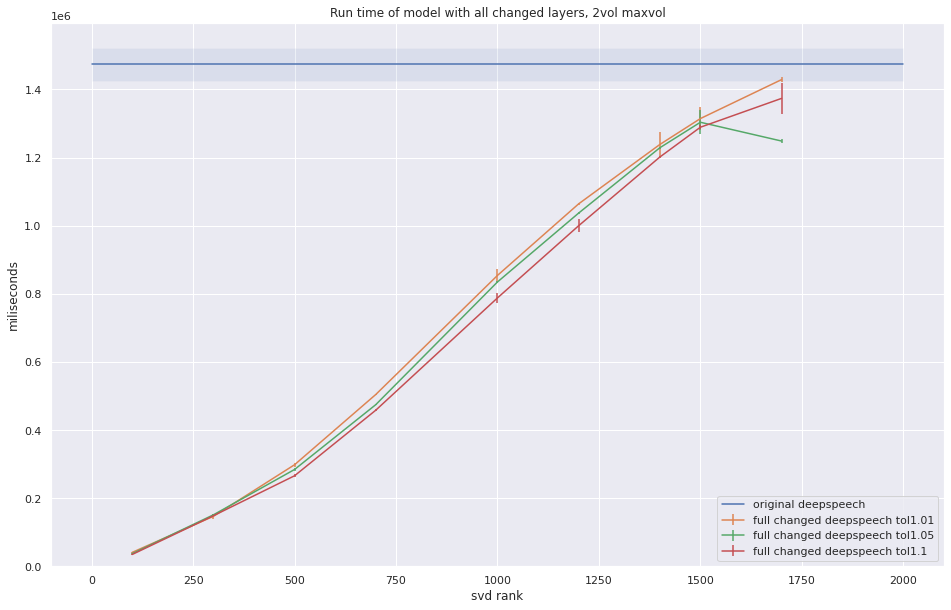

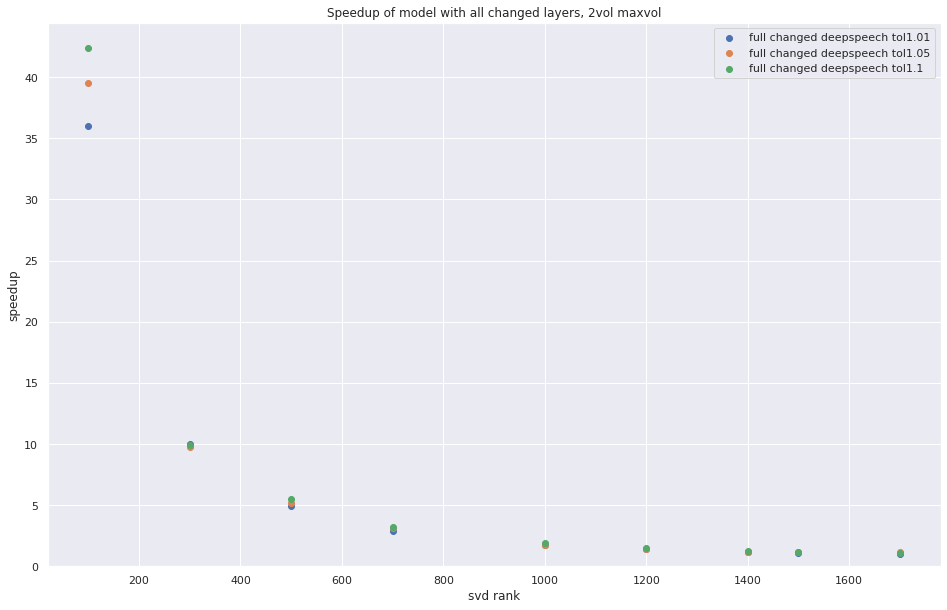

In [12]:
plt.figure(figsize=(16, 10))
plt.title('Run time of model with all changed layers and time dimension set to 20, 2vol maxvol')
plt.xlabel('svd rank')
plt.ylabel('miliseconds')
plt.plot([0, 2000], [ref_time, ref_time], label='original deepspeech')
plt.fill_between([0, 2000], [ref_time - ref_std, ref_time - ref_std], [ref_time + ref_std, ref_time + ref_std], alpha=0.1)
for tol in [1.01, 1.05, 1.1]:
    curr_res = speed_results[(speed_results['tol'] == tol) & (speed_results['maxvol_type'] == '2vol')]
    plt.errorbar(curr_res['rank'], curr_res['avg'], yerr=curr_res['std'], label=f'full changed deepspeech tol{tol}')
plt.ylim([0, None])
plt.legend()
plt.show()

plt.figure(figsize=(16, 10))
plt.title('Speedup of model with all changed layers, 2vol maxvol')
plt.xlabel('svd rank')
plt.ylabel('speedup')
for tol in [1.01, 1.05, 1.1]:
    curr_res = speed_results[(speed_results['tol'] == tol) & (speed_results['maxvol_type'] == '2vol')]
    plt.scatter(curr_res['rank'], ref_time/curr_res['avg'], label=f'full changed deepspeech tol{tol}')
plt.ylim([0, None])
plt.legend()

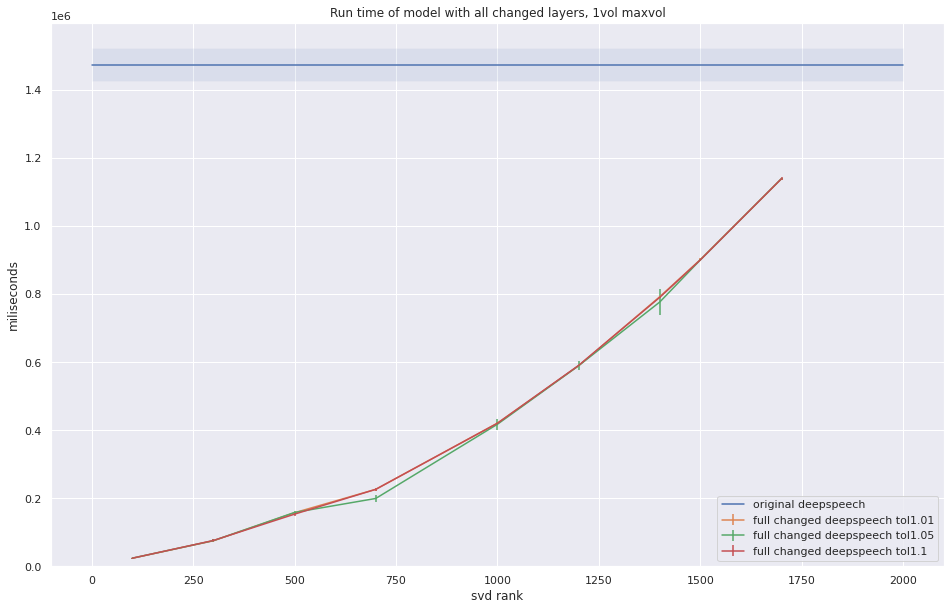

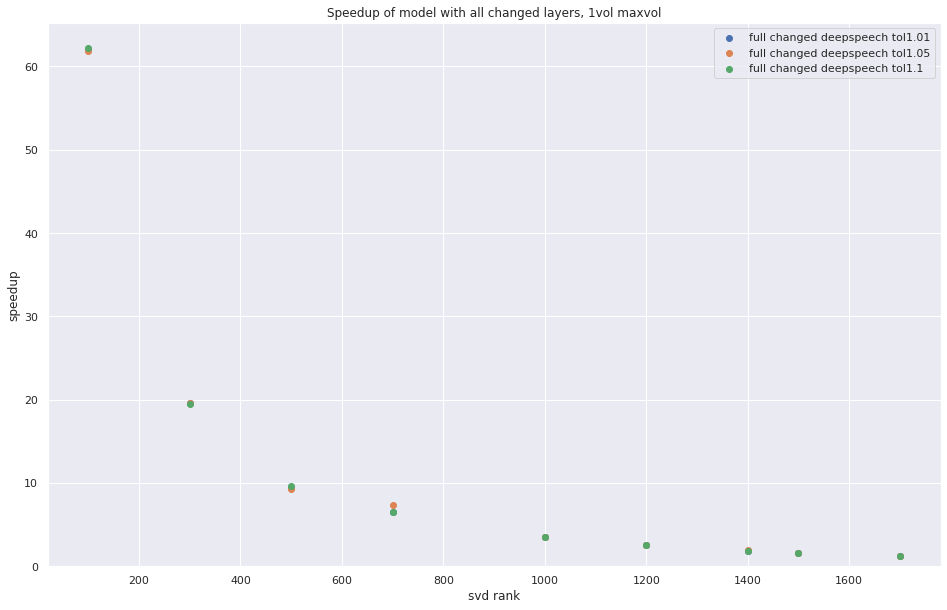

In [13]:
plt.figure(figsize=(16, 10))
plt.title('Run time of model with all changed layers and time dimension set to 20, 1vol maxvol')
plt.xlabel('svd rank')
plt.ylabel('miliseconds')
plt.plot([0, 2000], [ref_time, ref_time], label='original deepspeech')
plt.fill_between([0, 2000], [ref_time - ref_std, ref_time - ref_std], [ref_time + ref_std, ref_time + ref_std], alpha=0.1)
for tol in [1.01, 1.05, 1.1]:
    curr_res = speed_results[(speed_results['tol'] == tol) & (speed_results['maxvol_type'] == '1vol')]
    plt.errorbar(curr_res['rank'], curr_res['avg'], yerr=curr_res['std'], label=f'full changed deepspeech tol{tol}')
plt.ylim([0, None])
plt.legend()
plt.show()

plt.figure(figsize=(16, 10))
plt.title('Speedup of model with all changed layers, 1vol maxvol')
plt.xlabel('svd rank')
plt.ylabel('speedup')
for tol in [1.01, 1.05, 1.1]:
    curr_res = speed_results[(speed_results['tol'] == tol) & (speed_results['maxvol_type'] == '1vol')]
    plt.scatter(curr_res['rank'], ref_time/curr_res['avg'], label=f'full changed deepspeech tol{tol}')
plt.ylim([0, None])
plt.legend()